## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [24]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [25]:
train, test = keras.datasets.cifar10.load_data()

In [26]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [27]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [28]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [29]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [31]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                 keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]


In [33]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau
import itertools

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(nesterov=True, momentum=0.95),  # 優化器設置先不設置 learning_rate
                 keras.optimizers.Adam(),
                 keras.optimizers.RMSprop()]
reduce_lr_factor = [0.99, 0.5, 0.1]
reduce_lr_patient = [3, 5, 10]

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim_class, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, reduce_lr_patient)):
    keras.backend.clear_session()  # 清除舊的模型和圖
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    
    # 每次創建新模型
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    # 每次創建新的優化器，並指定 learning_rate
    optim = optim_class.from_config(optim_class.get_config())  # 使用新模型創建新的優化器
    optim.learning_rate = LEARNING_RATE
    
    # 編譯模型
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    # 設置 ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    # 訓練模型
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr])
    
    # 收集結果
    exp_name_tag = (f"optimizer: {optim_class}, reduce_factor: {reduce_factor}, reduce_patient: {reduce_patient}")
    results[exp_name_tag] = {
        'train-loss': model.history.history["loss"],
        'valid-loss': model.history.history["val_loss"],
        'train-acc': model.history.history["accuracy"],
        'valid-acc': model.history.history["val_accuracy"]
    }


Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2024 - loss: 2.4628 - val_accuracy: 0.1680 - val_loss: 2.1581 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3713 - loss: 1.8065 - val_accuracy: 0.2903 - val_loss: 1.9824 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4201 - loss: 1.6498 - val_accuracy: 0.3691 - val_loss: 1.8284 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4469 - loss: 1.5715 - val_accuracy: 0.4079 - val_loss: 1.7183 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4690 - loss: 1.5128 - val_accuracy: 0.4178 - val_loss: 1.6464 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4827 - loss: 1.4695 - val_accuracy: 0.4390 - val_loss: 1.5933 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4937 - loss: 1.4407 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2007 - loss: 2.5184 - val_accuracy: 0.1655 - val_loss: 2.1785 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3762 - loss: 1.8043 - val_accuracy: 0.2749 - val_loss: 2.0159 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4228 - loss: 1.6502 - val_accuracy: 0.3533 - val_loss: 1.8442 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4489 - loss: 1.5692 - val_accuracy: 0.4033 - val_loss: 1.7188 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4736 - loss: 1.5112 - val_accuracy: 0.4258 - val_loss: 1.6423 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4828 - loss: 1.4706 - val_accuracy: 0.4403 - val_loss: 1.5842 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4940 - loss: 1.4348 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1881 - loss: 2.5658 - val_accuracy: 0.1782 - val_loss: 2.1436 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3705 - loss: 1.8016 - val_accuracy: 0.2843 - val_loss: 1.9785 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4231 - loss: 1.6442 - val_accuracy: 0.3646 - val_loss: 1.8303 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4497 - loss: 1.5739 - val_accuracy: 0.4052 - val_loss: 1.7102 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4681 - loss: 1.5186 - val_accuracy: 0.4371 - val_loss: 1.6244 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4818 - loss: 1.4732 - val_accuracy: 0.4495 - val_loss: 1.5746 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5019 - loss: 1.4330 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1996 - loss: 2.5138 - val_accuracy: 0.2058 - val_loss: 2.1349 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3740 - loss: 1.7914 - val_accuracy: 0.3230 - val_loss: 1.9674 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4231 - loss: 1.6466 - val_accuracy: 0.3801 - val_loss: 1.8259 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4499 - loss: 1.5664 - val_accuracy: 0.4054 - val_loss: 1.7298 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4694 - loss: 1.5162 - val_accuracy: 0.4333 - val_loss: 1.6381 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4837 - loss: 1.4704 - val_accuracy: 0.4387 - val_loss: 1.5990 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4982 - loss: 1.4306 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2006 - loss: 2.4860 - val_accuracy: 0.1852 - val_loss: 2.1646 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3773 - loss: 1.7945 - val_accuracy: 0.2562 - val_loss: 2.0339 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4245 - loss: 1.6421 - val_accuracy: 0.3505 - val_loss: 1.8624 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4463 - loss: 1.5744 - val_accuracy: 0.3930 - val_loss: 1.7474 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4715 - loss: 1.5114 - val_accuracy: 0.4279 - val_loss: 1.6450 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4902 - loss: 1.4643 - val_accuracy: 0.4354 - val_loss: 1.6091 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5009 - loss: 1.4308 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1903 - loss: 2.5446 - val_accuracy: 0.1993 - val_loss: 2.1445 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3705 - loss: 1.8146 - val_accuracy: 0.2929 - val_loss: 2.0062 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4176 - loss: 1.6612 - val_accuracy: 0.3561 - val_loss: 1.8572 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4475 - loss: 1.5784 - val_accuracy: 0.3980 - val_loss: 1.7352 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4662 - loss: 1.5237 - val_accuracy: 0.4196 - val_loss: 1.6485 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4819 - loss: 1.4766 - val_accuracy: 0.4351 - val_loss: 1.5975 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4947 - loss: 1.4437 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2067 - loss: 2.5270 - val_accuracy: 0.2203 - val_loss: 2.1392 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3723 - loss: 1.8001 - val_accuracy: 0.3075 - val_loss: 1.9882 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4224 - loss: 1.6418 - val_accuracy: 0.3681 - val_loss: 1.8336 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4530 - loss: 1.5681 - val_accuracy: 0.4001 - val_loss: 1.7158 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4732 - loss: 1.5037 - val_accuracy: 0.4255 - val_loss: 1.6392 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4895 - loss: 1.4571 - val_accuracy: 0.4425 - val_loss: 1.5860 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5040 - loss: 1.4206 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1880 - loss: 2.5642 - val_accuracy: 0.1835 - val_loss: 2.1424 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3716 - loss: 1.8187 - val_accuracy: 0.2991 - val_loss: 1.9928 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4207 - loss: 1.6629 - val_accuracy: 0.3692 - val_loss: 1.8366 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4445 - loss: 1.5851 - val_accuracy: 0.4063 - val_loss: 1.7119 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4682 - loss: 1.5183 - val_accuracy: 0.4318 - val_loss: 1.6272 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4847 - loss: 1.4763 - val_accuracy: 0.4409 - val_loss: 1.5922 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4991 - loss: 1.4317 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2067 - loss: 2.5147 - val_accuracy: 0.2285 - val_loss: 2.1185 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3735 - loss: 1.8047 - val_accuracy: 0.2905 - val_loss: 1.9983 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4148 - loss: 1.6602 - val_accuracy: 0.3762 - val_loss: 1.8518 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4506 - loss: 1.5677 - val_accuracy: 0.4050 - val_loss: 1.7300 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4721 - loss: 1.5106 - val_accuracy: 0.4286 - val_loss: 1.6408 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4878 - loss: 1.4596 - val_accuracy: 0.4466 - val_loss: 1.5827 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4988 - loss: 1.4311 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3218 - loss: 2.0072 - val_accuracy: 0.2303 - val_loss: 2.2837 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4736 - loss: 1.4945 - val_accuracy: 0.2974 - val_loss: 1.9907 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5148 - loss: 1.3790 - val_accuracy: 0.3764 - val_loss: 1.7537 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5473 - loss: 1.2932 - val_accuracy: 0.4120 - val_loss: 1.6840 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5745 - loss: 1.2094 - val_accuracy: 0.3662 - val_loss: 1.9017 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5950 - loss: 1.1570 - val_accuracy: 0.4442 - val_loss: 1.5754 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6175 - loss: 1.0973 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3246 - loss: 2.0451 - val_accuracy: 0.2254 - val_loss: 2.0792 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4737 - loss: 1.4979 - val_accuracy: 0.3389 - val_loss: 1.8439 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5097 - loss: 1.3862 - val_accuracy: 0.3846 - val_loss: 1.7305 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5433 - loss: 1.2990 - val_accuracy: 0.3869 - val_loss: 1.7362 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5743 - loss: 1.2141 - val_accuracy: 0.3791 - val_loss: 1.7380 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5981 - loss: 1.1538 - val_accuracy: 0.4200 - val_loss: 1.6476 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6237 - loss: 1.0847 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3183 - loss: 2.0323 - val_accuracy: 0.1882 - val_loss: 2.3873 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4685 - loss: 1.5170 - val_accuracy: 0.3192 - val_loss: 1.9796 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5050 - loss: 1.4025 - val_accuracy: 0.3499 - val_loss: 1.8437 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5436 - loss: 1.3037 - val_accuracy: 0.3772 - val_loss: 1.7417 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5639 - loss: 1.2393 - val_accuracy: 0.4180 - val_loss: 1.6658 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5897 - loss: 1.1706 - val_accuracy: 0.3978 - val_loss: 1.7283 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6105 - loss: 1.1156 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3163 - loss: 2.0211 - val_accuracy: 0.1726 - val_loss: 2.5976 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4646 - loss: 1.5066 - val_accuracy: 0.3342 - val_loss: 1.8714 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5160 - loss: 1.3803 - val_accuracy: 0.3696 - val_loss: 1.7562 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5409 - loss: 1.3020 - val_accuracy: 0.3708 - val_loss: 1.7483 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5691 - loss: 1.2333 - val_accuracy: 0.3960 - val_loss: 1.6834 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5899 - loss: 1.1655 - val_accuracy: 0.4358 - val_loss: 1.5975 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6066 - loss: 1.1128 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3180 - loss: 2.0188 - val_accuracy: 0.2001 - val_loss: 2.2156 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4707 - loss: 1.4999 - val_accuracy: 0.3360 - val_loss: 1.8378 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5144 - loss: 1.3716 - val_accuracy: 0.3712 - val_loss: 1.8128 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5480 - loss: 1.2827 - val_accuracy: 0.3163 - val_loss: 2.0595 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5722 - loss: 1.2204 - val_accuracy: 0.3803 - val_loss: 1.7263 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5961 - loss: 1.1591 - val_accuracy: 0.3916 - val_loss: 1.7197 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6219 - loss: 1.0821 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3301 - loss: 1.9852 - val_accuracy: 0.1762 - val_loss: 2.5677 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4722 - loss: 1.4965 - val_accuracy: 0.3249 - val_loss: 1.8673 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5193 - loss: 1.3718 - val_accuracy: 0.3406 - val_loss: 1.8431 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5502 - loss: 1.2779 - val_accuracy: 0.3706 - val_loss: 1.7294 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5749 - loss: 1.2115 - val_accuracy: 0.3680 - val_loss: 1.8287 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5990 - loss: 1.1439 - val_accuracy: 0.4127 - val_loss: 1.6428 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6213 - loss: 1.0779 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3248 - loss: 2.0207 - val_accuracy: 0.1683 - val_loss: 2.4180 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4713 - loss: 1.5103 - val_accuracy: 0.3393 - val_loss: 1.8946 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5167 - loss: 1.3791 - val_accuracy: 0.3281 - val_loss: 1.8860 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5415 - loss: 1.3030 - val_accuracy: 0.3823 - val_loss: 1.7392 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5739 - loss: 1.2188 - val_accuracy: 0.4140 - val_loss: 1.6360 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5956 - loss: 1.1509 - val_accuracy: 0.4457 - val_loss: 1.5677 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6210 - loss: 1.0828 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3177 - loss: 2.0426 - val_accuracy: 0.1830 - val_loss: 2.5663 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4687 - loss: 1.5074 - val_accuracy: 0.3605 - val_loss: 1.8470 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5148 - loss: 1.3772 - val_accuracy: 0.3816 - val_loss: 1.6939 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5456 - loss: 1.2901 - val_accuracy: 0.3658 - val_loss: 1.7757 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5666 - loss: 1.2253 - val_accuracy: 0.3956 - val_loss: 1.7393 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5933 - loss: 1.1584 - val_accuracy: 0.3854 - val_loss: 1.7591 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6127 - loss: 1.1024 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3224 - loss: 2.0042 - val_accuracy: 0.1531 - val_loss: 2.6609 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4692 - loss: 1.5077 - val_accuracy: 0.3429 - val_loss: 1.8728 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5157 - loss: 1.3777 - val_accuracy: 0.3401 - val_loss: 1.8354 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5479 - loss: 1.2867 - val_accuracy: 0.3454 - val_loss: 1.8465 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5747 - loss: 1.2158 - val_accuracy: 0.4257 - val_loss: 1.6445 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5970 - loss: 1.1498 - val_accuracy: 0.3720 - val_loss: 1.8897 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6204 - loss: 1.0910 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3080 - loss: 2.0895 - val_accuracy: 0.2284 - val_loss: 2.1086 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4470 - loss: 1.5519 - val_accuracy: 0.2991 - val_loss: 1.8658 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4986 - loss: 1.4213 - val_accuracy: 0.2839 - val_loss: 1.9705 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5275 - loss: 1.3382 - val_accuracy: 0.3525 - val_loss: 1.8171 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5460 - loss: 1.2821 - val_accuracy: 0.4143 - val_loss: 1.6611 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5681 - loss: 1.2245 - val_accuracy: 0.4141 - val_loss: 1.6714 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5891 - loss: 1.1625 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3078 - loss: 2.0914 - val_accuracy: 0.2178 - val_loss: 2.1598 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4540 - loss: 1.5483 - val_accuracy: 0.3161 - val_loss: 1.8918 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4961 - loss: 1.4263 - val_accuracy: 0.3580 - val_loss: 1.8334 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5299 - loss: 1.3263 - val_accuracy: 0.3889 - val_loss: 1.6992 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5511 - loss: 1.2679 - val_accuracy: 0.3683 - val_loss: 1.9242 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5734 - loss: 1.2136 - val_accuracy: 0.3955 - val_loss: 1.7953 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5935 - loss: 1.1573 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3067 - loss: 2.1147 - val_accuracy: 0.1875 - val_loss: 2.2252 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4513 - loss: 1.5513 - val_accuracy: 0.2511 - val_loss: 2.1353 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4964 - loss: 1.4133 - val_accuracy: 0.3756 - val_loss: 1.7276 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5273 - loss: 1.3294 - val_accuracy: 0.3461 - val_loss: 1.8775 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5559 - loss: 1.2674 - val_accuracy: 0.3882 - val_loss: 1.7022 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5714 - loss: 1.2100 - val_accuracy: 0.3296 - val_loss: 1.9592 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5987 - loss: 1.1452 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3110 - loss: 2.0890 - val_accuracy: 0.2064 - val_loss: 2.1971 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4507 - loss: 1.5595 - val_accuracy: 0.2449 - val_loss: 2.1032 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4926 - loss: 1.4330 - val_accuracy: 0.3470 - val_loss: 1.8614 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5239 - loss: 1.3446 - val_accuracy: 0.3026 - val_loss: 2.0658 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5506 - loss: 1.2752 - val_accuracy: 0.3514 - val_loss: 1.8824 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5661 - loss: 1.2303 - val_accuracy: 0.4280 - val_loss: 1.6027 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5910 - loss: 1.1674 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3114 - loss: 2.0791 - val_accuracy: 0.1333 - val_loss: 2.7333 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4448 - loss: 1.5594 - val_accuracy: 0.2811 - val_loss: 2.1174 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4979 - loss: 1.4223 - val_accuracy: 0.3174 - val_loss: 1.8906 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5248 - loss: 1.3474 - val_accuracy: 0.3189 - val_loss: 2.1572 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5532 - loss: 1.2783 - val_accuracy: 0.3746 - val_loss: 1.7851 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5682 - loss: 1.2243 - val_accuracy: 0.3915 - val_loss: 1.7599 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5849 - loss: 1.1813 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3084 - loss: 2.1094 - val_accuracy: 0.1396 - val_loss: 2.4844 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4459 - loss: 1.5580 - val_accuracy: 0.3266 - val_loss: 1.8764 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4877 - loss: 1.4441 - val_accuracy: 0.2764 - val_loss: 2.0681 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5267 - loss: 1.3348 - val_accuracy: 0.3822 - val_loss: 1.7345 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5502 - loss: 1.2753 - val_accuracy: 0.3863 - val_loss: 1.7130 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5706 - loss: 1.2190 - val_accuracy: 0.3950 - val_loss: 1.7064 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5937 - loss: 1.1526 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3102 - loss: 2.0897 - val_accuracy: 0.1498 - val_loss: 2.2302 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4443 - loss: 1.5726 - val_accuracy: 0.2543 - val_loss: 2.1756 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4901 - loss: 1.4313 - val_accuracy: 0.3509 - val_loss: 1.8542 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5206 - loss: 1.3508 - val_accuracy: 0.3617 - val_loss: 1.8005 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5439 - loss: 1.2803 - val_accuracy: 0.3640 - val_loss: 1.8309 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5703 - loss: 1.2129 - val_accuracy: 0.3660 - val_loss: 1.8761 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5911 - loss: 1.1606
Epoch 7: 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3053 - loss: 2.1310 - val_accuracy: 0.2244 - val_loss: 2.0566 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4517 - loss: 1.5648 - val_accuracy: 0.3158 - val_loss: 1.8957 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4931 - loss: 1.4341 - val_accuracy: 0.3692 - val_loss: 1.7948 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5267 - loss: 1.3504 - val_accuracy: 0.3118 - val_loss: 1.9517 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5519 - loss: 1.2757 - val_accuracy: 0.3297 - val_loss: 1.9034 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5649 - loss: 1.2296 - val_accuracy: 0.3933 - val_loss: 1.7271 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5842 - loss: 1.1778 - val_acc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Dense)           │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer2 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer3 (Dense)           │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 922,378 (3.52 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3035 - loss: 2.1159 - val_accuracy: 0.1581 - val_loss: 2.6283 - learning_rate: 0.0010
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4433 - loss: 1.5769 - val_accuracy: 0.2804 - val_loss: 2.0112 - learning_rate: 0.0010
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5004 - loss: 1.4310 - val_accuracy: 0.3095 - val_loss: 1.9665 - learning_rate: 0.0010
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5225 - loss: 1.3496 - val_accuracy: 0.3198 - val_loss: 2.0240 - learning_rate: 0.0010
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5541 - loss: 1.2762 - val_accuracy: 0.3745 - val_loss: 1.8089 - learning_rate: 0.0010
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5717 - loss: 1.2105 - val_accuracy: 0.4047 - val_loss: 1.7238 - learning_rate: 0.0010
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5963 - loss: 1.1526 - val_acc

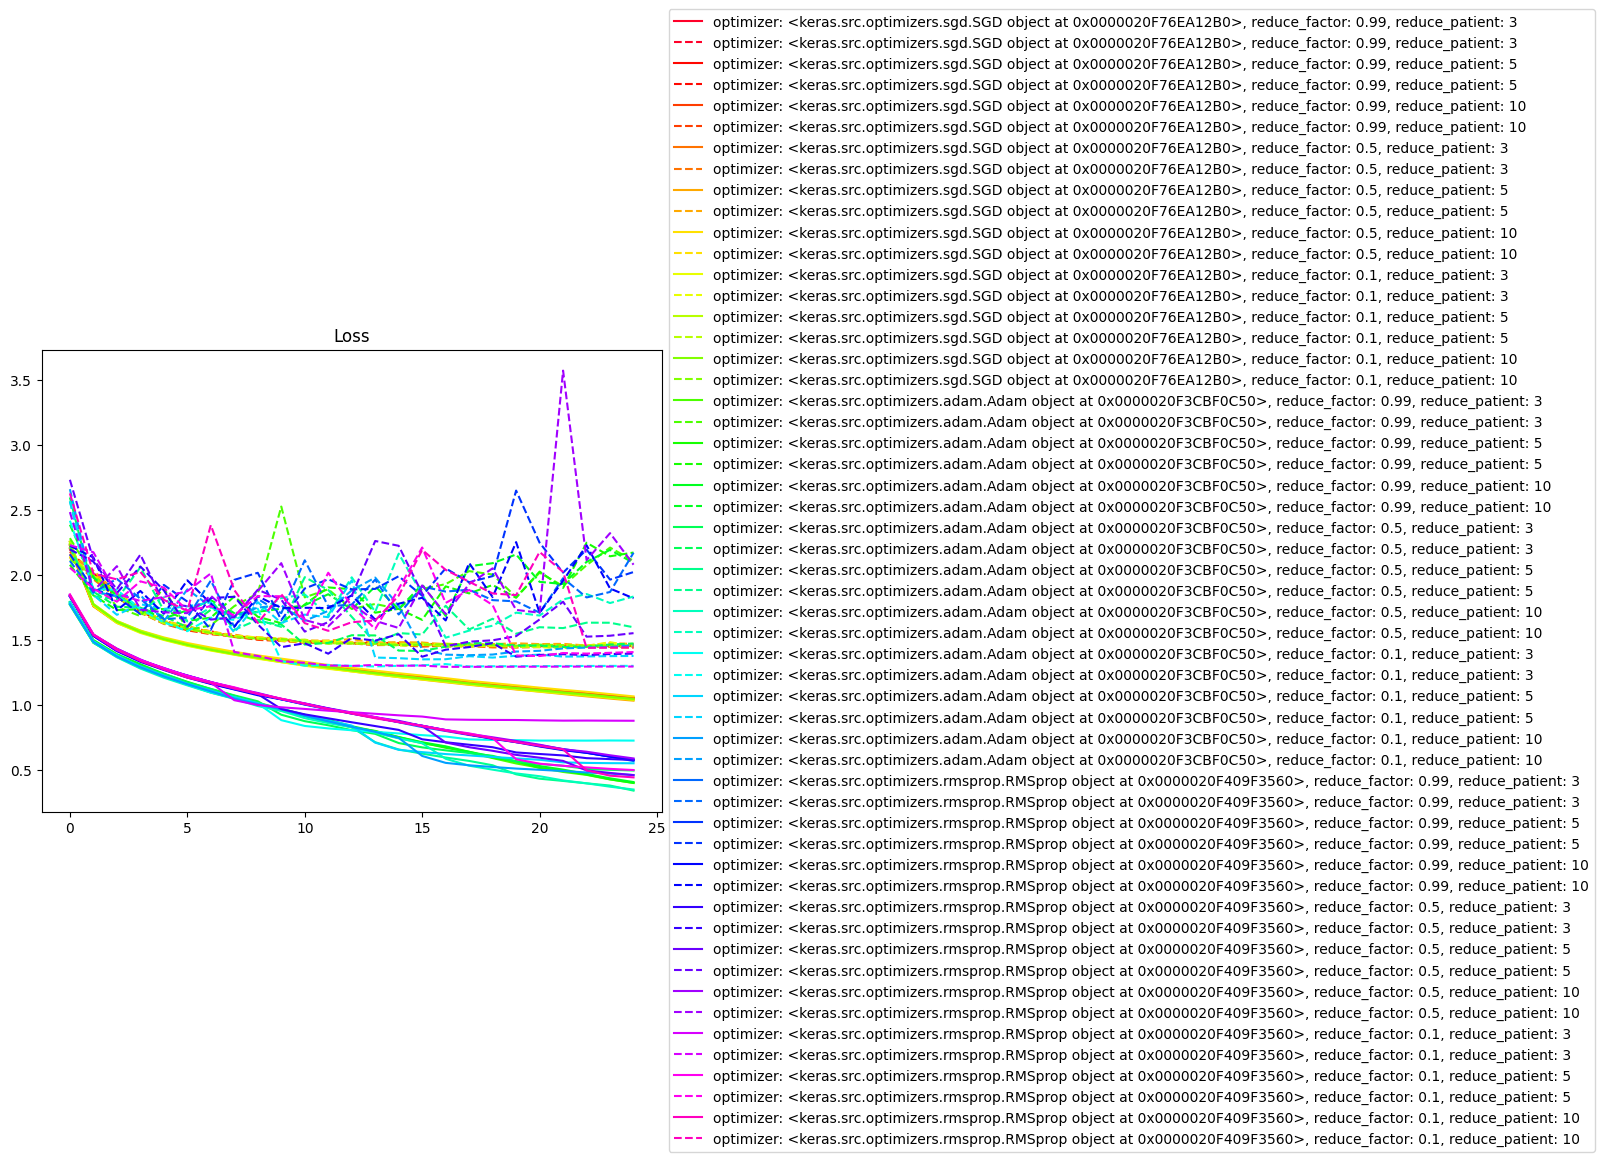

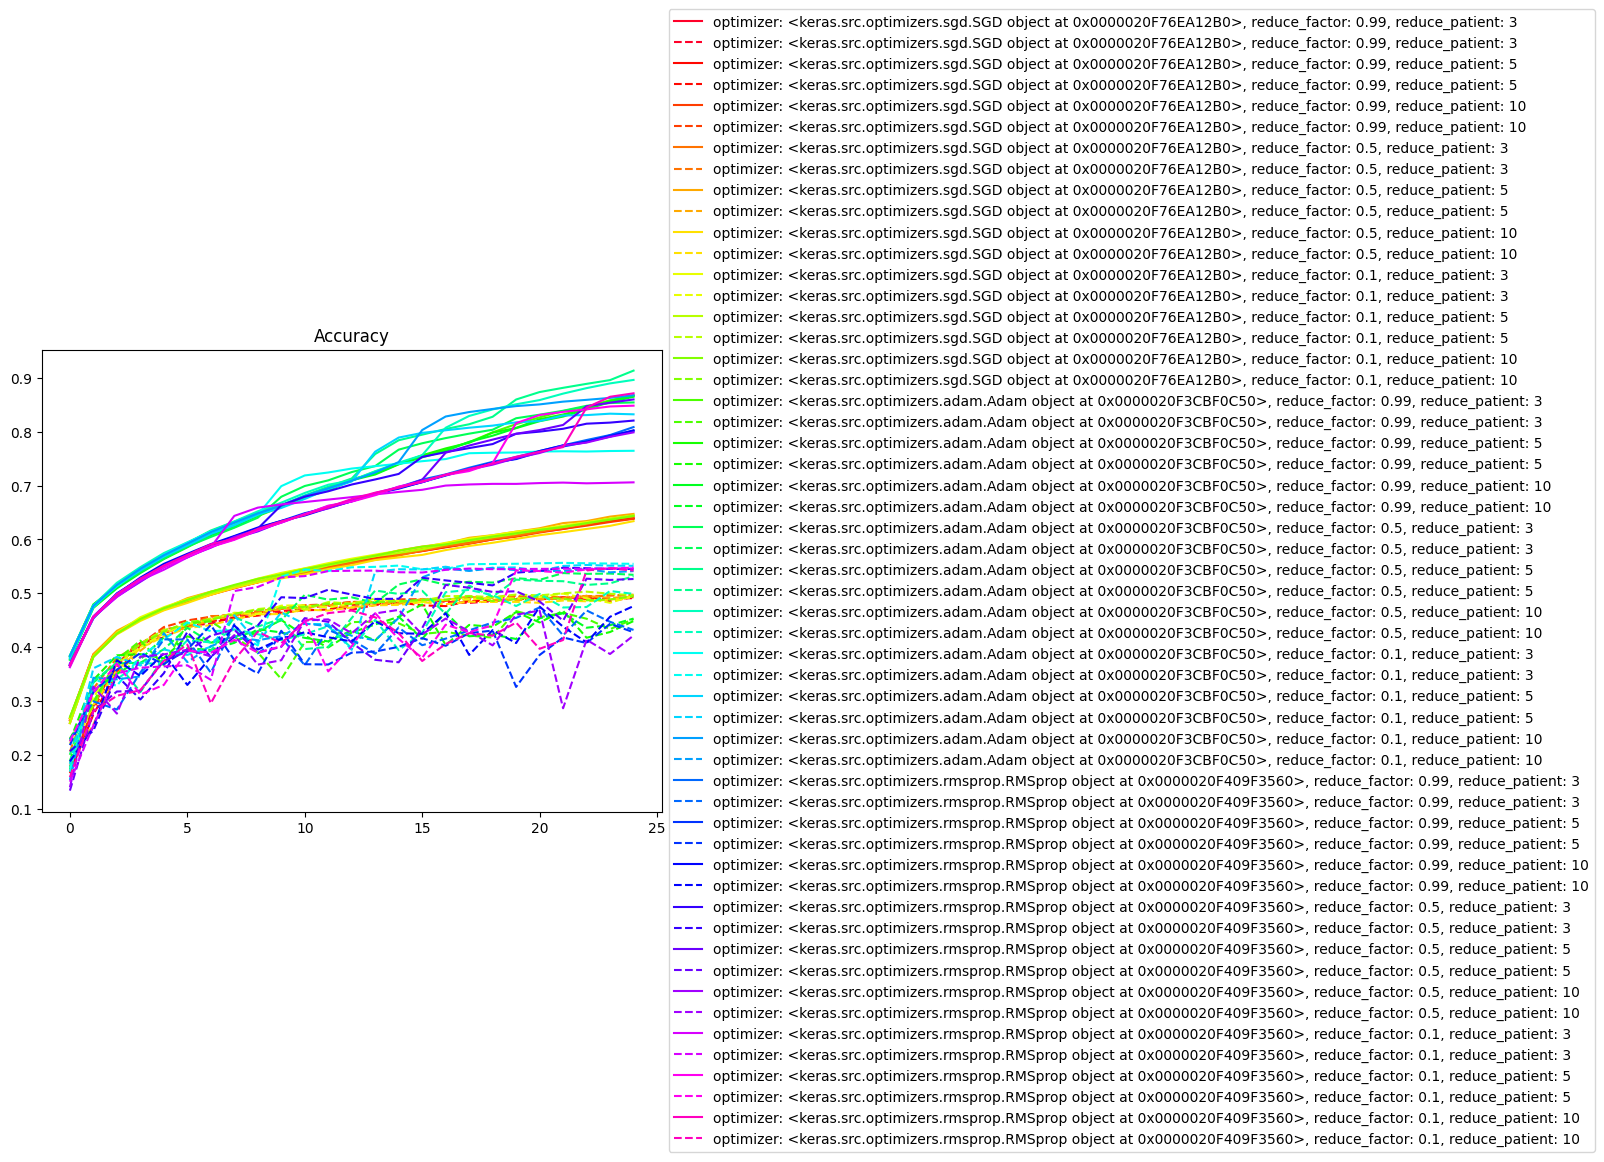

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()